In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *

### Initialize Tagger

In [2]:
from tagger import Tagger
tagger = Tagger()

### Load Model and Data

In [30]:
model_path = '/dfs/scratch0/mccreery/repos/metal/metal/mmtl/aws/output/2019_04_04_15_29_09/1/logdir/2019_04_05/QNLI,STSB,MRPC,QQP,WNLI,RTE,MNLI,SST2,COLA_19_58_22/'
task_name = 'COLA'
split = 'dev'
filepath = f'{task_name}_{split}_error_analysis.tsv'

In [31]:
# Load model and data
model, dl = load_data_and_model(model_path,task_name,split)

# Create DataFrame of Raw Data, Predictions, and Labels
print('Creating dataframe')
df_error = create_dataframe(task_name, model, dl)
print('Created dataframe')

# Save (and reload) DataFrame
csv_path = '/'.join(model_path.split('/')[0:-1])
save_dataframe(df_error, filepath)

Could not find kwarg "generate_uids" in destination dict.
Using random seed: 727953
Using soft attention head
Loading COLA Dataset



Loading model from path: /dfs/scratch0/mccreery/repos/metal/metal/mmtl/aws/output/2019_04_04_15_29_09/1/logdir/2019_04_05/QNLI,STSB,MRPC,QQP,WNLI,RTE,MNLI,SST2,COLA_19_58_22/model.pkl
Creating dataframe


1043it [00:24, 42.76it/s]

Created dataframe
Saved dataframe to:  COLA_dev_error_analysis.tsv


In [32]:
df_error = load_dataframe(filepath)

In [33]:
df_error.head()

,Unnamed: 0,sentence1,sentence2,score,label,uid,pred,is_wrong
0,0,the sailors rode the breeze clear of the rock...,NaN,0.996689,1,CoLA/dev.tsv:1,1,False
1,1,the weights made the rope stretch over the pu...,NaN,0.993293,1,CoLA/dev.tsv:2,1,False
2,2,the mechanical doll wr ##ig ##gled itself loo...,NaN,0.682839,1,CoLA/dev.tsv:3,1,False
3,3,"if you had eaten more , you would want less .",NaN,0.983470,1,CoLA/dev.tsv:4,1,False
4,4,"as you eat the most , you want the least .",NaN,0.504353,0,CoLA/dev.tsv:5,1,True


## Sandbox for Error Analysis

**0. Some basic statistics.**

Confusion Matrix and Performance Metrics

In [34]:
df_error['label'].values

array([1, 1, 1, ..., 0, 1, 1])

In [35]:
from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()
confusion_matrix(Y_gold, Y_preds, pretty_print=True, normalize=True)
print()

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")

        y=1    y=2   
 l=1  *0.791  0.209  
 l=2   0.333 *0.667  

Accuracy: 0.764
Precision: 0.791
Recall: 0.895
F1: 0.840


Plotting Predictions and Predicted Probabilistic Label Distribution

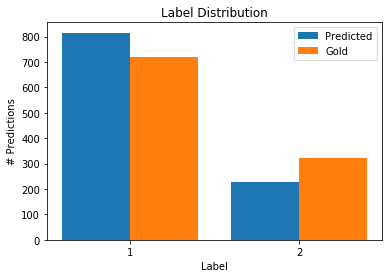

Plotting probabilities from the first column of Y_probs


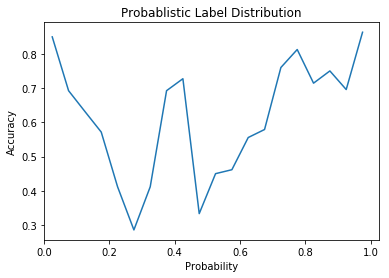

In [36]:
from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_plot
    )
plot_predictions_histogram(Y_preds, Y_gold, title="Label Distribution")
plot_calibration_plot(Y_probs, Y_gold, title="Probablistic Label Distribution")

**1. We want to look at examples that are "barely" wrong and "barely" right since we have hope for boosts here.**

In [27]:
print("\033[1mBARELY WRONG\033[0;0m")
print_barely_wrong(df_error, thresh=0.2, n=3)

print()

print("\033[1mBARELY RIGHT\033[0;0m")
print_barely_right(df_error, thresh=0.2, n=3)

BARELY WRONG
62 matches were found with the given criteria.

sentence1: 	 vote for you ! 
sentence2: 	nan
score: 	0.6110
label: 	0

sentence1: 	 i know which book jose didn ' t read for class , and which book lilly did it for him . 
sentence2: 	nan
score: 	0.6698
label: 	0

sentence1: 	 any man didn ' t eat dinner . 
sentence2: 	nan
score: 	0.6148
label: 	0


BARELY RIGHT
97 matches were found with the given criteria.

sentence1: 	 john believed it that bill was tar ##dy . 
sentence2: 	nan
score: 	0.4116
label: 	0

sentence1: 	 we wanted to invite someone , but we couldn ' t decide who to . 
sentence2: 	nan
score: 	0.3485
label: 	0

sentence1: 	 mary asked me if , in st . louis , john could rent a house cheap . 
sentence2: 	nan
score: 	0.6891
label: 	1



**2. We also want to look at examples we got completely wrong since that could point to a systematic bias in the data/model. It could also help us find examples in the dataset that are mislabeled by human annotators**

In [29]:
print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0.9, n=10)

# print("\033[1mVERY RIGHT\033[0;0m")
# print_very_right(df_error, thresh=0.9, n=)

VERY WRONG
32 matches were found with the given criteria.

sentence1: 	 sandy was trying to work out which students would be able to solve a certain problem , but she wouldn ' t tell us which one . 
sentence2: 	nan
score: 	0.9047
label: 	0

sentence1: 	 i saw even the student . 
sentence2: 	nan
score: 	0.0776
label: 	1

sentence1: 	 this is the senator to whose mother ' s friend ' s sister ' s i sent the letter . 
sentence2: 	nan
score: 	0.0939
label: 	1

sentence1: 	 she asked was alison coming to the party . 
sentence2: 	nan
score: 	0.0789
label: 	1

sentence1: 	 chris was handed sandy a note by pat . 
sentence2: 	nan
score: 	0.9052
label: 	0

sentence1: 	 max seemed to be trying to force ted to leave the room , and walt to stay a little longer . 
sentence2: 	nan
score: 	0.9475
label: 	0

sentence1: 	 i know that meg ' s attracted to harry , but they don ' t know who . 
sentence2: 	nan
score: 	0.9142
label: 	0

sentence1: 	 we investigated the area for bombs . 
sentence2: 	nan
score:

**3. To find systematic errors, we can also look for correlations between certain features and the incorrectness a la Socratic**


We can make this way more sophisticated by perhaps using embeddings instead of this simple [BoW featurization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [10]:
print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
for i in range(3):
    print_systematic_wrong(df_error)

SYSTEMATIC EXAMPLES
award winning
supreme court
new government
22 year old


/dfs/scratch0/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


patti nson

8 matches were found with the given criteria.

UID:  RTE/dev.tsv:77
sentence1: 	 a closely divided u . s . supreme court said on thursday its 2002 ruling that ju ##ries and not judges must impose a death sentence applies only to future cases , a decision that may affect more than 100 death row inmates . 
sentence2: 	 the supreme court decided that only judges can impose the death sentence . 
score: 	0.9890
label: 	0

award winning
supreme court said
new government
22 year old
mark antony

8 matches were found with the given criteria.

UID:  RTE/dev.tsv:247
sentence1: 	 new york boasts the largest number of billionaire ##s , with 40 residing in the big apple . the world ' s youngest billionaire is 22 - year - old hind hari ##ri , daughter of assassinated former lebanese prime minister raf ##ik hari ##ri . 
sentence2: 	 the number of billionaire ##s increases . 
score: 	0.9920
label: 	0

award winning
new government
supreme court said
22 year old
mark antony

8 matches were f

## Designing Labeling Functions

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

In [11]:
def LF_number(idx):
    sentence1_nums = [int(s) for s in df_error['sentence1'][idx].split() if s.isdigit()]
    sentence2_nums = [int(s) for s in df_error['sentence2'][idx].split() if s.isdigit()]
    common_nums = len(set(sentence1_nums).intersection(set(sentence2_nums)))
    
    if (sentence1_nums == []) or (sentence2_nums == []):
        return 0
    
    if common_nums > 0:
        return 2
    else:
        return 1

In [12]:
print_row(df_error.iloc[70])
print("LF_label: ", LF_number(70)-1)

print()
print()
print_row(df_error.iloc[254])
print("LF_label: ", LF_number(254)-1)

sentence1: 	 about 33 . 5 million people live in this massive con ##ur ##bation . i would guess that 95 % of the 5 , 000 officially foreign - capital firms in japan are based in tokyo . 
sentence2: 	 about 33 . 5 mi ##ili ##on people live in tokyo . 
score: 	0.0056
label: 	1

LF_label:  1


sentence1: 	 monica meadows , a 22 - year - old model from atlanta , was shot in the shoulder on a subway car in new york city . 
sentence2: 	 monica meadows , 23 , was shot in shoulder while riding a subway car in new york city 
score: 	0.9879
label: 	0

LF_label:  0


**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.

In [13]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

from collections import Counter
def common_words(s1,s2):
    s1_set = set(Counter(s1.split()))
    s2_set = set(Counter(s2.split()))
    return len(s1_set.intersection(s2_set))/float(min(len(s1_set),len(s2_set)))

In [14]:
def LF_words(idx):
    ratio = common_words(df_error['sentence1'][idx], df_error['sentence2'][idx])
    if ratio < 0.3:
        return 1
    if (ratio <= 1.0) and (ratio > 0.4):
        return 2
    else:
        return 0

In [15]:
print_row(df_error.iloc[150])
print("LF_label: ", LF_words(150)-1)

print()
print()
print_row(df_error.iloc[95])
print("LF_label: ", LF_words(95)-1)

sentence1: 	 quebec woman and her mother accused of plotting to kill a four - year - old girl . 
sentence2: 	 quebec woman murdered a four - year - old girl . 
score: 	0.0143
label: 	0

LF_label:  1


sentence1: 	 i asked myself how to understand the ' twilight ' s success . and i have come to the idea that when you really believe in something , sooner or later it will become real . so , i guess this is what happened with robert patti ##nson . last year he was just an unknown actor who ' s biggest role was in a pair of " harry potter " movies . now , not only that twilight is competing with ' harry potter ' , but robert patti ##nson is one of the most famous young actors who sucked $ 37 ##3 . 4 million from global box offices . so the movie about a vampire boy who falls in love with a normal girl , begun a real hysteria . and patti ##nson has a lot to do with it ! . 
sentence2: 	 robert patti ##nson is a vampire . 
score: 	0.9955
label: 	0

LF_label:  1


### Analyze Labeling Functions

In [16]:
L = np.zeros((np.shape(df_error)[0],2))
for i in range(df_error.shape[0]):
    L[i,0] = LF_number(i)
    L[i,1] = LF_words(i)

Labeling Function Summary

In [17]:
from metal.analysis import lf_summary
from scipy.sparse import csr_matrix    

L_sparse = csr_matrix(L)
lf_summary(L_sparse,Y=df_error.label+1)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1.0, 2.0]",0.158845,0.155235,0.025271,22,22,0.500000
1,"[1.0, 2.0]",0.949458,0.155235,0.025271,148,115,0.562738


In [18]:
incorrect = set(np.where(df_error.is_wrong == True)[0])
LF1_set = set(np.where(L[:,0]-1. == df_error.label)[0])
LF2_set = set(np.where(L[:,1]-1. == df_error.label)[0])

print("Percentage Corrected by LF_num: ", 100.*len(LF1_set.intersection(incorrect))/float(len(incorrect)))
print("Percentage Corrected by LF_words: ", 100.*len(LF2_set.intersection(incorrect))/float(len(incorrect)))

Percentage Corrected by LF_num:  6.8493150684931505
Percentage Corrected by LF_words:  31.506849315068493


## Using Model for Task A to Predict on Train Set for Task B

We start with QNLI and RTE since those are both about `entailment` and `not_entailment`

In [19]:
# model config (needs to be the same as parameters used for training)
bert_model = "bert-base-uncased"
max_len = 256
bert_output_dim = 768
max_datapoints = -1
dl_kwargs = {"batch_size": 32, "shuffle": False}

In [20]:
# 02/19/19
model_paths = {
    'MNLI_SAN': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/17-2-2019/MNLI_SAN_02_27_41/',
    'QNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QNLI_09_56_46/',
    'STSB': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/STSB_09_46_46/',
    'SST2': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/SST2_06_01_35/',
    'COLA': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/COLA_05_49_39/',
    'RTE':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/RTE_06_32_37/',
    'WNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/WNLI_06_38_32/',
    'QQP': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QQP_06_47_48/',
    'MRPC':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/MRPC_09_40_25/'
}

In [21]:
# source_task_name = 'QNLI'
# target_task_name = 'RTE'

# #create source task
# source_task = create_tasks(
#     task_names=[source_task_name],
#     bert_model=bert_model,
#     max_len=max_len,
#     dl_kwargs=dl_kwargs,
#     splits=['test'],
#     max_datapoints=max_datapoints,
# )[0]

# # load source model weights 
# source_model_path = os.path.join(model_paths[source_task_name], 'best_model.pth')
# source_model = MetalModel([source_task], verbose=False, device=0)
# source_model.load_weights(source_model_path)
# source_model.eval()
    
    
# #create target task
# target_task = create_tasks(
#     task_names=[target_task_name],
#     bert_model=bert_model,
#     max_len=max_len,
#     dl_kwargs=dl_kwargs,
#     splits=['train'],
#     max_datapoints=max_datapoints,
# )[0]

# # predict on target task train set
# target_task.name = source_task_name #HACK FOR LINE 225 in METAL_MODEL.PY
# Y, Y_probs, Y_preds = source_model._predict_probs(
#     target_task, split='train', return_preds=True)

# # true labels for target task train set
# Y_true = []
# for x, y in tqdm(list(target_task.data_loaders['train'])):
#     Y_true += list(y.numpy())

In [22]:
# confident_idx = list(np.where(np.abs(Y_probs[:,0]-0.5) >= 0.4)[0])
# Y_true = np.array(Y_true)
# print (f'Accuracy of {source_task_name} model on {target_task_name}: {np.mean(Y_preds[confident_idx] == Y_true[confident_idx])}')